<a href="https://colab.research.google.com/github/emicscs/SNeFR-MRI/blob/main/static_slices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
from einops import rearrange, repeat
import einops
from glob import glob
from math import log
import math
from tqdm import tqdm
import pickle
from staf import StafLayer
from staf import INR
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The image resolution is: 540x360


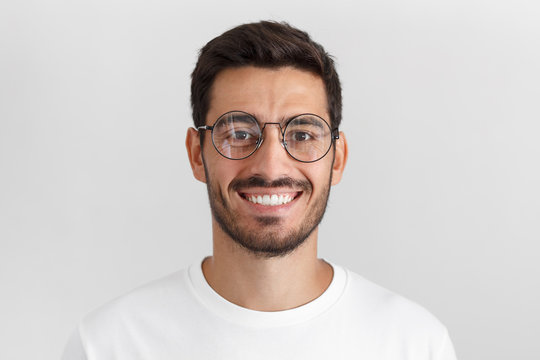

In [ ]:
###--Load image with PIL and display--###
image_path = "./headshot.jpg"
image = Image.open(image_path).convert("RGB")
W, H = image.size


#downsampling if necessary
#H = H//10
#W = W//10

image = image.resize((W, H))

# Print the dimensions
print(f"The image resolution is: {W}x{H}")
image.show()

In [ ]:
###---Create DataFrame---###
rgb_array = np.array(image)
height, width = rgb_array.shape[:2]

# Create coordinate grids
x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))

# Flatten everything and create df
x_flat = x_coords.ravel()
y_flat = y_coords.ravel()
r_flat = rgb_array[:, :, 0].ravel()
g_flat = rgb_array[:, :, 1].ravel()
b_flat = rgb_array[:, :, 2].ravel()
df = pd.DataFrame({a
    "x_pos": x_flat/(width-1),
    "y_pos": y_flat/(height-1),
    "R": r_flat/np.max(r_flat),
    "G": g_flat/np.max(g_flat),
    "B": b_flat/np.max(b_flat)
})

df.head()

,x_pos,y_pos,R,G,B
0,0.000000,0.0,0.878431,0.878431,0.878431
1,0.001855,0.0,0.878431,0.878431,0.878431
2,0.003711,0.0,0.878431,0.878431,0.878431
3,0.005566,0.0,0.878431,0.878431,0.878431
4,0.007421,0.0,0.878431,0.878431,0.878431


In [ ]:
###---Basic INR MLP Architecture, using ReLU---###
class ImageINRModel(torch.nn.Module):

    def __init__(self, input_size, hidden_size = 256, output_size = 3, num_hidden = 4):
        super(ImageINRModel, self).__init__()

        self.input = torch.nn.Linear(input_size, hidden_size)
        self.hidden = nn.ModuleList()

        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        self.hidden = nn.Sequential(*layers)
        self.output = torch.nn.Linear(hidden_size, output_size)
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        x = self.sig(x)

        return x

In [ ]:
#Pass in a frequency array and and xy grid, return cos/sin of 2x/f and 2y/f for f in freq
def fourier_encode(xy: torch.Tensor, freq: torch.Tensor) -> torch.Tensor:
    xy = xy.unsqueeze(1)
    freq1 = freq[0:len(freq)//2 ]
    freq2 = freq[len(freq)//2:]


    freq1 = torch.tensor(freq1, dtype = torch.float32).view(1, -1, 1)
    freq2 = torch.tensor(freq2, dtype = torch.float32).view(1, -1, 1)

    scaled1 = 2 * torch.pi * (1/freq1) * xy
    scaled2 = 2 * torch.pi * (1/freq2) * xy

    sin_feat = torch.sin(scaled1)
    cos_feat = torch.cos(scaled2)


    features = torch.cat([sin_feat, cos_feat], dim=-1)
    return features.view(xy.shape[0], -1)

In [ ]:
#Dataset where input is simply [x,y] tensor
class ImageINRDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.x = torch.tensor(dataframe[['x_pos', 'y_pos']].values, dtype=torch.float32)
        self.y = torch.tensor(dataframe[['R', 'G', 'B']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
#Dataset to customize type of positional encoding of input
class ImageINRDatasetFourier(Dataset):
    def __init__(self, dataframe, fourier = False, gaussian = False, num_freq = 1, freq_param = None, freq_file = 'freq.pkl', gauss_scale = 1):
        self.dataframe = dataframe

        if (fourier or gaussian) == False:
            #No positional encoding, just x and y
            self.x = torch.tensor(dataframe[['x_pos', 'y_pos']].values, dtype=torch.float32)
        else:
            if fourier == True:
                #fourier encoding with just cos/sin 2x and 2y
                freq = [1, 1]
            elif gaussian == True:
                #normal random sample num_freq frequencies for cos and sin to include in positional encoding
                freq = np.random.normal(0, 1, size = num_freq*2)*gauss_scale

                #Need to save these frequencies because they must also be used for pos encoding inputs at inference time
                pickle.dump(freq, open(freq_file, "wb"))
            else:
                #if you want to pass in custom frequencies
                freq = freq_param

            x = dataframe['x_pos']
            y = dataframe['y_pos']
            xy = torch.tensor(np.stack([x, y], axis=-1), dtype = torch.float32)
            self.x = fourier_encode(xy, freq)

        self.y = torch.tensor(dataframe[['R', 'G', 'B']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
#Function to train with different encoding types, set model_type to use different encodings
#STAF is a new INR that uses trainable parameter sinusoidal activation functions, just wanted to experiment with it: https://arxiv.org/abs/2502.00869
from tqdm import tqdm
import pickle
def train( num_freq, model_type, model_file = 'checkpoint.pth', loss_file = 'losses', freq_file = 'freq.pkl', gauss_scale = 1):
    epoch_losses = []
    min_loss = 100

    if model_type == 'fourier':
        data = ImageINRDatasetFourier(df, fourier = True, num_freq = 1)
        model = ImageINRModel(input_size = 4).to(device)
    elif model_type == 'standard':
        data = ImageINRDataset(df)
        model = ImageINRModel(input_size = 2).to(device)
    elif model_type == 'gaussian':
        data = ImageINRDatasetFourier(df, gaussian = True, num_freq = num_freq, freq_file = freq_file, gauss_scale = gauss_scale)
        model = ImageINRModel(input_size = 4*num_freq).to(device)
    elif model_type == 'STAF':
        data = ImageINRDataset(df)
        model = INR(2, 256, 4, 3).to(device)
    else:
        print('invalid model_type')
        return

    train_dataloader = DataLoader(data, batch_size=8192, shuffle=True)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 2000

    for epoch in tqdm(range(num_epochs)):
        model.train()

        epoch_loss = 0

        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)


            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()


        if epoch % 20 == 0:
            #print(f"Epoch {epoch}, Loss: {epoch_loss / len(train_dataloader)}")
            epoch_losses.append(epoch_loss)
            pickle.dump(epoch_losses, open(f"{loss_file}_losses.pkl", "wb"))
            if epoch_loss < min_loss:

                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    # Add other relevant information as needed
                }

                torch.save(checkpoint, model_file)

In [ ]:
train(num_freq = 1, model_type = 'standard', model_file ='headshot_standard.pth', loss_file = 'headshot_standard')

In [ ]:
train(num_freq = 1, model_type = 'fourier', model_file ='headshot_fourier.pth', loss_file = 'headshot_fourier')

In [ ]:
train(num_freq = 256, model_type = 'gaussian', model_file ='headshot_gaussian_1.pth', loss_file = 'headshot_gaussian_1', freq_file = 'freq_1.pkl', gauss_scale = 1)

In [ ]:
train(num_freq = 256, model_type = 'gaussian', model_file ='headshot_gaussian_10.pth', loss_file = 'headshot_gaussian_10', freq_file = 'freq_10.pkl', gauss_scale = 10)

In [ ]:
train(num_freq = 1, model_type = 'STAF', model_file ='headshot_STAF.pth', loss_file = 'headshot_STAF')

The image resolution is: 540x360


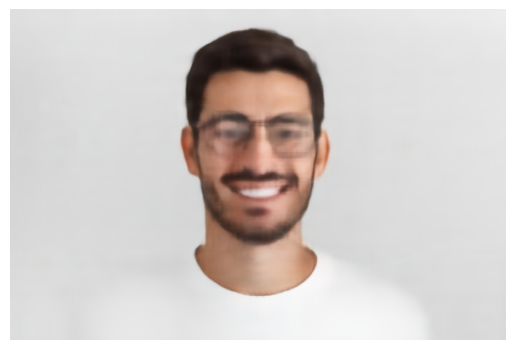

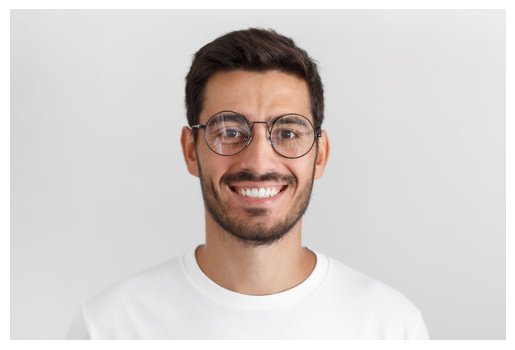

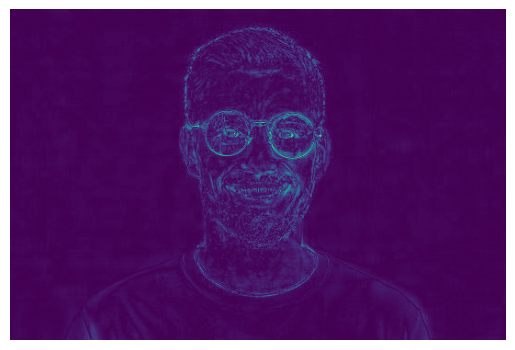

In [ ]:
#Evaluation cell, uncomment the correct model and corresponding lines, make sure the paremeters match and the correct frequency file is loaded if using gaussian


# Use this for standard
#model = ImageINRModel(input_size = 2)

# Use this for fourier
#model = ImageINRModel(input_size = 4)

# use this for gaussian or passing in custom frequencies, change this to correct number of frequencies from training
num_freq = 256
model = ImageINRModel(input_size = 4*num_freq)

#model = INR(2, 256, 4, 3) #Use this as model if evaluating STAF model

#define path to model checkpoint
path = './headshot_gaussian_10.pth'
checkpoint = torch.load(path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Create normalized grid: x in [0, 1], y in [0, 1]
x = np.linspace(0, 1, W)
y = np.linspace(0, 1, H)
xx, yy = np.meshgrid(x, y)  # shape: (H, W)

X = torch.tensor(np.stack([xx, yy], axis=-1).reshape(-1, 2), dtype = torch.float32)  # shape: (H*W, 2)

# Use this for gaussian to load corresponding frequencies, otherwise comment out
with open('./freq_10.pkl', 'rb') as file:
    freq = pickle.load(file)

X = fourier_encode(X, freq = freq) # comment this line out if using standard or STAF, use freq = [1, 1] for fourier or freq = freq for gaussian

with torch.no_grad():
    Y = model(X)

image = Y.reshape(H, W, 3)
image = torch.clip(image, 0, 1)

gt = Image.open("./headshot.jpg").convert("RGB")

#W, H = gt.size[0]//10, gt.size[1]//10 #if you downsampled the training image
gt = gt.resize((W, H))

to_tensor = transforms.ToTensor()
gt = to_tensor(gt)
gt = rearrange(gt, 'k i j -> i j k')

dif = torch.sum(torch.abs(gt - image), axis = 2)/3


print(f"The image resolution is: {W}x{H}")
plt.imshow(image)
plt.axis('off')
plt.show()

plt.imshow(gt)
plt.axis('off')
plt.show()

plt.imshow(dif)
plt.axis('off')
plt.show()